In [237]:
%matplotlib nbagg
from ipywidgets import interact, interactive, IntSlider, HBox, VBox, Tab, Layout, Box, Label, BoundedFloatText
import ipywidgets as widgets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import numpy as np
from scipy.optimize import minimize
import pandas as pd

display(HTML("<style>.container { width:100% !important; }</style>"))
plt.style.use('ggplot')



In [ ]:
# Take the number of classes and the proportions of each (e.g equal proportion, one dominant class, etc)
# Create confusion matrix based on specified number of samples. Distribute them based on a similar rule: all correct, half correct, some correct, etc.
# Samples must match total sum of ROWS, but columns have no restrictions
# Ensure that weights add up to one always
# Plot producers accuracy vs confidence interval for different combinations of class weights and error distributions. 
# Make the plot interactive maybe? E.g. drop down to see different cases? Or just plot them separately. 
# Total number of samples per map class is probably not that important, what matters is the PROPORTIONS of samples that get incorrectly classified

In [3]:
ni =  np.array((50, 400,  75,  50,  75,  50,  50,  50,  50,  50,  50,  50,  50))
pix = np.array((635555, 460268682, 15765829, 694635, 27223852, 6558022, 6998656, 642978, 222843, 213419, 386, 130391, 884436))
props = pix / pix.sum()

def calc_ci(fcount, fprop, fw, fpcount, fpprop):
    pix = np.array((635555, 460268682, 15765829, 694635, 27223852, 6558022, 6998656, 642978, 222843, 213419, 386, 130391, 884436))
    wh = np.array((0.001221658, fw, 0.03030493, 0.001335221, 0.05232944, 0.01260577, 0.01345275, 0.001235926, 0.0004283468,0.0004102321, 7.419657e-07, 0.0002506364, 0.001700055))
    map_area = (pix * 30.0**2) / (100.0 **2)
    total_area = map_area.sum()
    ni =  np.array((50, fcount,  75,  50,  75,  50,  50,  fpcount,  50,  50,  50,  50,  50))
    ref_count = np.array((7, fcount*fprop, 0, 0, 0, 0, 0, fpcount*fpprop, 10,  1,  1, 17, 11))
    area_prop = (ref_count * wh) / ni
    prod_acc = (area_prop / area_prop.sum())[7] # we only need it for the forest to pasture class
    area_prop_se = np.sqrt(np.sum((wh * area_prop - area_prop**2) / (ni - 1)))
    area_ci = area_prop_se * 1.96 * total_area
    return(area_ci, prod_acc)



<IPython.core.display.Javascript object>


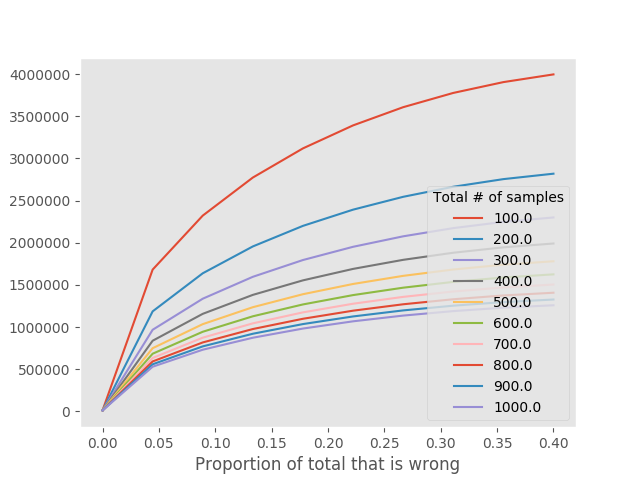

In [4]:
# Plot "half CI" with multiple forest sample sizes and proportion of them that actually correspond to 
# forest to pasture according to the reference data.
fcount = np.linspace(100, 1000, 10)
fprop = np.linspace(0, 0.4, 10)
forest_sample = np.zeros((10,10))
prod_acc = np.zeros((10,10))
fw = 0.8847243 # Forest strata weight

for i in range(len(fcount)):
    for j in range(len(fprop)):
        forest_sample[j, i] = calc_ci(fcount[i], fprop[j], fw,  50, 1)[0]
        prod_acc[j, i] = calc_ci(fcount[i], fprop[j], fw,  50, 1)[1]

plt.plot(fprop, forest_sample)
plt.grid()
plt.xlabel('Proportion of total that is wrong')
plt.ylabel('CI')
plt.legend(fcount, loc=4, title="Total # of samples")



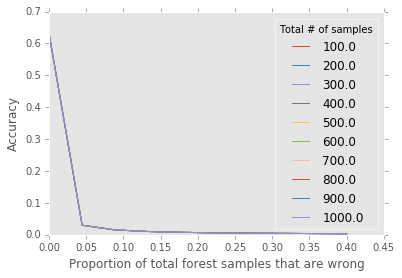

In [21]:
# Plot accuracies?
plt.plot(fprop, prod_acc)
plt.grid()
plt.xlabel('Proportion of total forest samples that are wrong')
plt.ylabel('Accuracy')
plt.legend(fcount, loc=4, title="Total # of samples")


/home/paulo/miniconda3/envs/yatsm_copy/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


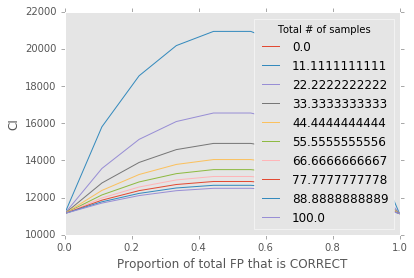

In [22]:
# Do the same but varying the forest to pasture counts. This plot doesn't make any sense!
fp_sample = np.zeros((10,10))
fpprop = np.linspace(0, 1, 10)
fpcount = np.linspace(0, 100, 10)

for i in range(len(fpcount)):
    for j in range(len(fpprop)):
        fp_sample[j, i] = calc_ci(400, 0, fw, fpcount[i], fpprop[j])[0]
        prod_acc[j, i] = calc_ci(400, 0, fw, fpcount[i], fpprop[j])[1]


plt.plot(fpprop, fp_sample)
plt.grid()
plt.xlabel('Proportion of total FP that is CORRECT')
plt.ylabel('CI')
plt.legend(fpcount, loc=4, title="Total # of samples")


In [ ]:
fp_sample

In [ ]:
plt.plot(fprop, prod_acc)
plt.grid()
plt.xlabel('Proportion of total FP that is CORRECT')
plt.ylabel('Prod Accuracy')
plt.legend(fcount, loc=4, title="Total # of samples")


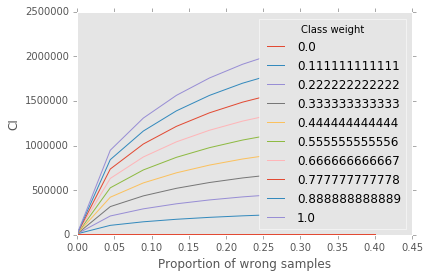

In [23]:
# Same thing but varying the class weight.
fp_sample = np.zeros((10,10))
fprop = np.linspace(0, 0.4, 10)
fweight = np.linspace(0, 1, 10)


for i in range(len(fweight)):
    for j in range(len(fprop)):
        fp_sample[j, i] = calc_ci(400, fprop[j], fweight[i], 50, 1)[0]


plt.plot(fprop, fp_sample)
plt.grid()
plt.xlabel('Proportion of wrong samples')
plt.ylabel('CI')
plt.legend(fweight, loc=4, title="Class weight")



## NEW ATTEMPT TO RELATED ACCURACIES AND CI

In [627]:
# Define a fnc to create a sample error matrix with a given set of properties

def calculate_weights(nclass, weight_dist):
    """Returns a weight distribution for given number of classes, 
    based on options that go from equal distribution to very unbalanced
    distribution
    """
    # Create weights
    if weight_dist == 'equal':
        wh = np.empty(nclass)
        wh.fill(1/nclass)
    elif weight_dist == 'unbalanced-linear':
        linseq = np.linspace(0.1,100, nclass)
        wh = (1 * linseq) / linseq.sum()
    elif weight_dist == 'unbalanced-geom':
        geomseq = np.geomspace(1,100, nclass)
        wh = (1 * geomseq) / geomseq.sum()
    elif weight_dist == 'very-unbalanced-geom':
        geomseq = np.geomspace(0.01,100, nclass)
        wh = (1 * geomseq) / geomseq.sum()
    
    # Invert weights to have bigger ones at the beginning
    wh = -np.sort(-wh)
    
    return wh


def adjust_values(values, target_sum):
    """Calculates the sum of the ceiling values and substracts from the
    largest value to match the desired total sum of the elements"""
    
    rounded_vals = np.ceil(values)
    totsum= rounded_vals.sum()

    while True:
        totsum = rounded_vals.sum()
        maxind = np.argmax(rounded_vals)
        if (totsum - target_sum) == 0:
            break
        else:
            rounded_vals[maxind] -= 1

    return rounded_vals        


def check_weights(nclass, weights):
    """Check if the number of weights equals number of classes and
    if they add up to 1
    """
    return (len(weights) == nclass) & (weights.sum() == 1.0)


def create_error_matrix(nclass, weight_dist, tot_sample_size, reference_dist, *kwargs):
    
    # Create pandas df to store everything
    datacols = ['ref{}'.format(i+1) for i in range(nclass)]
    datarows = ['map{}'.format(i+1) for i in range(nclass)]
    df = pd.DataFrame(columns=datacols)
    
    # Create weights, or use the ones passed in kwargs
    if len(kwargs) > 0:
        if ('strata_weights' in kwargs[0]) & (check_weights(nclass, kwargs[0]['strata_weights'])):
            wh = kwargs[0]['strata_weights']
        else:
            print("Error: Number of weights must be equal to number of classes and the sum add to 1")
            return
     
    else:
        wh = calculate_weights(nclass, weight_dist)
   
    
    # Create sample size per stratum, proportional to weight
    # Adjust sizes for the sum to match the input total
    ni = wh * tot_sample_size
    df['ni'] = adjust_values(ni, tot_sample_size)
    
    # Create perfect confusion matrix and modify it to match different scenarios
    pcmat = np.zeros((nclass, nclass))
    np.fill_diagonal(pcmat, df['ni'])
    diag = np.diag_indices(nclass)
        
    if reference_dist == 'perfect':
        out_cm = pcmat
    
    # Redistribute counts along rows using the same weights
    elif reference_dist == 'strata_weight_alike':
        wh = calculate_weights(nclass, weight_dist)
        
    elif reference_dist == 'custom':
        if len(kwargs) > 0:
            if ('custom_wh' in kwargs[0]) & (check_weights(nclass, kwargs[0]['custom_wh'])):
                wh = kwargs[0]['custom_wh']
            else:
                print("Error: Number of weights must be equal to number of classes and the sum add to 1")
                return
     
        else:
            print("Error: custom option requires an array of weights")
            
        
    # Get redistributed counts    
    out_cm = [wh * n for n in df['ni']]
    # Shift them to match the structure of the matrix
    out_cm = [np.roll(a, b) for a, b in zip(out_cm, diag[0])]
    # Adjust values for the sum to match the total sample size
    out_cm = [adjust_values(a, b) for a, b in zip(out_cm, df['ni'])]
    # Stack and calculate sum for verification purposes
    out_cm = np.vstack(out_cm)
    df['sum'] = out_cm.sum(axis=1)

    df['wh'] = wh
    df.iloc[:,0:nclass] = out_cm
    
    
    return df   

In [638]:
dftest = create_error_matrix(8, 'very-unbalanced-geom', 1000, 'strata_weight_alike')
dftest

,ref1,ref2,ref3,ref4,ref5,ref6,ref7,ref8,ni,sum,wh
0,528.0,143.0,39.0,11.0,3.0,1.0,1.0,1.0,727.0,727.0,0.731750
1,1.0,140.0,39.0,11.0,3.0,1.0,1.0,1.0,197.0,197.0,0.196306
2,1.0,1.0,34.0,11.0,3.0,1.0,1.0,1.0,53.0,53.0,0.052663
3,1.0,1.0,1.0,6.0,3.0,1.0,1.0,1.0,15.0,15.0,0.014128
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,4.0,4.0,0.003790
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,0.001017
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.000273
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.000073


In [635]:
#testw = np.array([.8,.05,.05,.05,.05,.05,.05,.05,.05,.05])
testw = np.array([.8,.1,.095,.005])
testsw = np.array([.25, .25, .25, .25])
kwargs = {'custom_wh': testw, 'strata_weights': testsw}
dftest = create_error_matrix(4, 'unbalanced-geom', 1000, 'custom', kwargs)
dftest

,ref1,ref2,ref3,ref4,ni,sum,wh
0,199.0,25.0,24.0,2.0,250.0,250.0,0.800
1,2.0,199.0,25.0,24.0,250.0,250.0,0.100
2,24.0,2.0,199.0,25.0,250.0,250.0,0.095
3,25.0,24.0,2.0,199.0,250.0,250.0,0.005


In [579]:
'custom_wh' in kwargs


True